In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy.interpolate import PchipInterpolator
from scipy.integrate import trapezoid

In [2]:
# Constants  (SI units)
AU    = 1.495979e+11
sigma = 5.670374419e-8
h_pl  = 6.62607015e-34
k_B   = 1.380649e-23
c_vac = 299792458.0

os.chdir('..')
os.chdir('..')
os.getcwd() # should be AGNI

'/home/ers1n25/AGNI'

# Make sure to only run cells above this one ONCE #

In [3]:
# Parameters
a = 1.154e-2         # Orbital distance [AU] from Gillon 2024

wave_min = 100.0    # nm
wave_max = 1e5      # nm
wave_bin = 3000     # integer

star_path = "./res/stellar_spectra/trappist-1.txt"
alb_path = "./res/surface_albedos/andesite.dat"

In [4]:
# Setup wavelength grid for calculation
obs_pts = np.logspace(np.log10(wave_min), np.log10(wave_max), wave_bin)
obs_bc = (obs_pts[1:] + obs_pts[:-1]) * 0.5     # bin centres
obs_bw = obs_pts[1:] - obs_pts[:-1]             # bin widths

In [5]:
# Load stellar spectrum
star_data = np.loadtxt(star_path).T
star_wl = star_data[0]
star_fl = star_data[1] * 0.001 # W m-2 nm-1
star_itp = PchipInterpolator(star_wl, star_fl) # At 1 AU

star = pd.DataFrame({
    'wavelength': star_data[0],
    'flux': star_data[1]
})

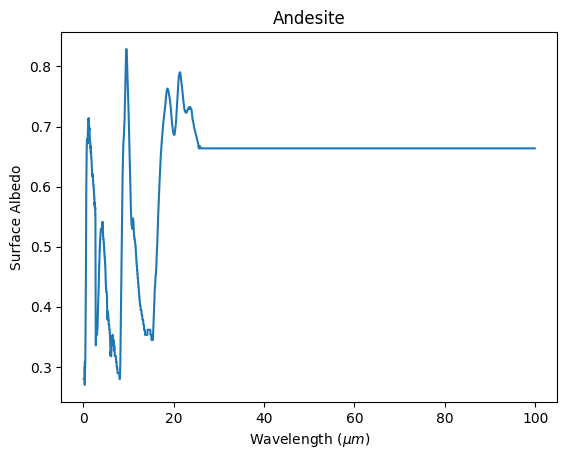

In [10]:
# Load albedo data
alb_data = np.loadtxt(alb_path, skiprows=1).T
alb_wl = list(alb_data[0])
alb_al = list(alb_data[1])

# extend range left
alb_wl = [0.0] + alb_wl
alb_al = [alb_al[0]] + alb_al

# extend range right
alb_wl.append(1e9)
alb_al.append(alb_al[-1])

# create interpolator
alb_itp = PchipInterpolator(alb_wl, alb_al)

# plot
plt.close("all")
# fig,ax = plt.subplots(figsize=(5,2))
# ax.plot(obs_bc, alb_itp(obs_bc))
# ax.set_xlim(left=100, right=5e3)
# ax.set(xlabel="Wavelength [nm]", ylabel=r"Surface albedo")
# plt.show()

plt.plot(obs_bc * 1e-3, alb_itp(obs_bc))
#plt.xlim(0, 20)
#plt.ylim(0, 1)
plt.xlabel(r'Wavelength ($\mu m$)')
plt.ylabel('Surface Albedo')
plt.title('Andesite')
plt.show()

In [ ]:
# # save albedo files in a slightly different format to use within HELIOS
# path = './res/surface_albedos/*.dat'

# for fname in glob.glob(path):
#     ddf = pd.read_table('%s'%fname, delimiter=' ', header=None, skiprows=1)
#     ddf.columns = ['wavelength', 'albedo']

#     wavelength = list(ddf['wavelength'])
#     albedo = list(ddf['albedo'])

#     # extend range left
#     wavelength = [0.0] + wavelength
#     albedo = [albedo[0]] + albedo

#     # extend range right
#     wavelength.append(1e9)
#     albedo.append(albedo[-1])

#     # create interpolator
#     albedo_itp = PchipInterpolator(wavelength, albedo)

#     new_ddf = pd.DataFrame({
#         'wavelength': obs_bc * 1e-3,
#         'albedo': albedo_itp(obs_bc)
#     })

#     file_name = os.path.splitext(os.path.basename(fname))[0]
#     new_ddf.to_csv('./out/%s'%file_name + '_new.dat', index=False, sep=' ')
#     print(new_ddf)

#     wavelength = []
#     albedo = []

      wavelength    albedo
0       0.100115  0.612800
1       0.100346  0.612800
2       0.100578  0.612800
3       0.100809  0.612800
4       0.101042  0.612800
...          ...       ...
2994   98.968910  0.308401
2995   99.197133  0.308401
2996   99.425882  0.308401
2997   99.655159  0.308401
2998   99.884965  0.308401

[2999 rows x 2 columns]
      wavelength    albedo
0       0.100115  0.474157
1       0.100346  0.474157
2       0.100578  0.474157
3       0.100809  0.474157
4       0.101042  0.474157
...          ...       ...
2994   98.968910  0.946402
2995   99.197133  0.946402
2996   99.425882  0.946402
2997   99.655159  0.946402
2998   99.884965  0.946402

[2999 rows x 2 columns]
      wavelength    albedo
0       0.100115  0.780785
1       0.100346  0.780785
2       0.100578  0.780785
3       0.100809  0.780785
4       0.101042  0.780785
...          ...       ...
2994   98.968910  0.432356
2995   99.197133  0.432356
2996   99.425882  0.432356
2997   99.655159  0.432356
2998 

In [ ]:
def evaluate_planck(wav:float, tmp:float):
    '''
    Evaluate the planck function at a given wavelength and temperature
    '''
    # Output value
    flx = 0.0

    # Convert nm to m
    wav = wav * 1.0e-9

    # Calculate planck function value [W m-2 sr-1 m-1]
    # http://spiff.rit.edu/classes/phys317/lectures/planck.html
    flx = 2.0 * h_pl * c_vac * (c_vac / wav**5.0) / ( np.exp(h_pl * c_vac / (wav * k_B * tmp)) - 1.0)

    # Integrate solid angle (hemisphere), convert units
    flx = flx * np.pi * 1.0e-9 # [W m-2 nm-1]

    return flx

In [ ]:
def fluxes(wav:float, wid:float, tmp:float):
    '''
    Calculate up/down fluxes at the surface of the planet at a given wavelength bin
    '''

    alb_s = alb_itp(wav)
    eps_s = 1-alb_s

    out = {} # W m-2

    thermal = evaluate_planck(wav, tmp) * wid
    out["LW_UP"] = thermal * eps_s
    out["LW_DN"] = 0.0

    stellar = star_itp(wav) * wid * (1/a)**2
    out["SW_DN"] = stellar
    out["SW_UP"] = stellar * alb_s

    return out


In [ ]:
def residual(tmp:float):
    '''
    Calculate bolometric residual flux at the surface
    '''

    up = 0.0
    dn = 0.0
    for i in range(len(obs_bc)):
        bc = obs_bc[i]
        bw = obs_bw[i]
        f = fluxes(bc, bw, tmp)
        up += f["LW_UP"] + f["SW_UP"]
        dn += f["LW_DN"] + f["SW_DN"]

    return dn-up


In [ ]:
# Solve for surface temperature which satisfies radiative equilibrium
sol = root_scalar(residual, x0=2000.0)
sol

      converged: True
           flag: converged
 function_calls: 20
     iterations: 10
           root: 510.41389458335624
         method: newton

In [ ]:
def emission_spectrum(tmp:float):
    '''
    Calculate emission spectrum (components) at a given temperature
    '''
    out = {
        "LW_UP":[],
        "SW_UP":[],
        "SW_DN":[],
        "UP":[]
    }
    for i in range(len(obs_bw)):
        bc = obs_bc[i]
        bw = obs_bw[i]

        f = fluxes(bc, bw, tmp)

        out["LW_UP"].append(f["LW_UP"]/bw)
        out["SW_UP"].append(f["SW_UP"]/bw)
        out["SW_DN"].append(f["SW_DN"]/bw)
        out["UP"].append((f["LW_UP"] + f["SW_UP"])/bw)

    for k in out.keys():
        out[k] = np.array(out[k], dtype=float)

    return out

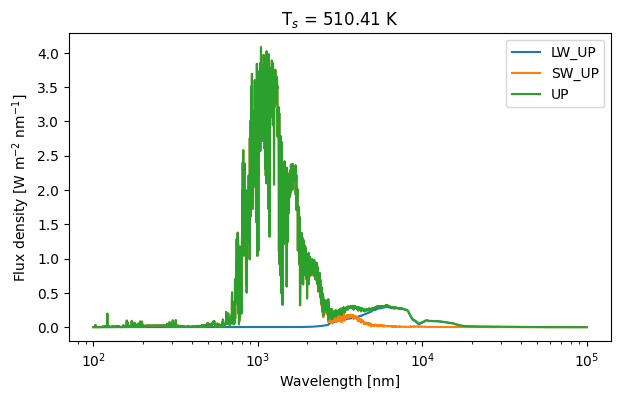

In [ ]:
# Plot emission spectrum

plt.close("all")

fig,ax = plt.subplots(figsize=(7,4))

tmp = float(sol.root)
emiss = emission_spectrum(tmp)

for k in ["LW_UP","SW_UP","UP"]:
    ax.plot(obs_bc, emiss[k], label=k)

# ax.plot(obs_bc, emiss["SW_UP"]/emiss["SW_DN"])

ax.set(title=r"T$_s$ = %.2f K"%tmp, xlabel="Wavelength [nm]", ylabel=r"Flux density [W m$^{-2}$ nm$^{-1}$]")
ax.set_xscale("log")
ax.legend()

plt.show()

# **Plot Relative Flux of Planet to Star Using Atmosphere Method**

In [13]:
# initialise pandas dataframe containing planetary emission data from this notebook
df = pd.DataFrame({
    'wavelength': obs_bc,
    'lw_up': emiss['LW_UP'],
    'sw_up': emiss['SW_UP'],
    'total': emiss['UP']
})

# read in stellar spectra of trappist-1
star = pd.read_csv('./res/stellar_spectra/trappist-1.txt', delimiter='\t', header=None, skiprows=2)
star.columns = ['wavelength', 'flux']

In [14]:
# convert spectral flux density of the planet at TOA into relative flux to the flux of the star to a distant observer (units of parts per million (dimensionless))
def correct_flux(star_flux_1_AU, planet_intensity_TOA):
    dist = AU # distance at which flux was given (1AU in m)
    radius = 6.378e6 * 1.116 # radius of the planet (m), from Gillon 2024

    # convert planet intensity into planet flux, no pi factor needed here as fluxes are used in this file
    planet_flux_TOA = planet_intensity_TOA
    # a factor of 10^6 is added to convert to parts per million (dimensionless)
    scale_factor = 1e6 * (radius / dist) ** 2

    return scale_factor * (planet_flux_TOA / star_flux_1_AU)

In [15]:
# plot model fluxes in units of parts per million (dimensionless)
def plot_flux(dataFrame):
    # convert from SI to cgs
    dataFrame['total_cgs'] = dataFrame['total'] * 1000

    # set up empty columns to hold closest wavelength value and associated stellar flux
    dataFrame['star_closest_wavelength'] = 0.0
    dataFrame['star_closest_flux'] = 0.0

    # find closest stellar data wavelength value to those used in the model and the associated stellar flux by homebrew interpolation
    for i in range(0, len(dataFrame['wavelength'])):
        dataFrame.loc[i, 'star_closest_wavelength'] = star['wavelength'][np.abs(star['wavelength'] - dataFrame['wavelength'][i]).argmin()]
        dataFrame.loc[i, 'star_closest_flux'] = star['flux'][np.abs(star['wavelength'] - dataFrame['wavelength'][i]).argmin()]

    # convert planet and star flux/intensity to relative flux
    dataFrame['relative_flux'] = correct_flux(dataFrame['star_closest_flux'], dataFrame['total_cgs'])

    # convert nanometres to micrometres
    dataFrame['microns'] = dataFrame['wavelength'] / 1000

    # plot graph
    plt.plot(dataFrame['microns'], dataFrame['relative_flux'], lw=0.8, color='k')

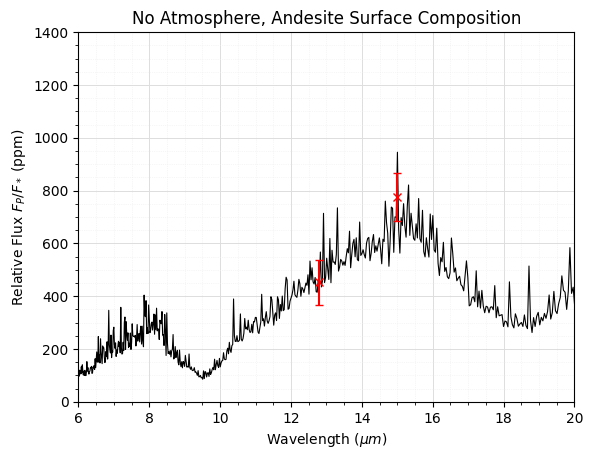

In [16]:
plot_flux(df)

# add literature values of secondary eclipse flux from Ducrot et. al. 2024
plt.errorbar(12.8, 452, yerr=86, marker='x', color='r', capsize=3)
plt.errorbar(15, 775, yerr=90, marker='x', color='r', capsize=3)

# add both major and minor grid lines
plt.grid(which='major', color='#DDDDDD', lw=0.7)
plt.grid(which='minor', color='#EEEEEE', ls=':', lw=0.5)
plt.minorticks_on()

# add title
plt.title('No Atmosphere, Andesite Surface Composition')

# set x and y axis limits
plt.xlim(6, 20)
plt.ylim(0, 1400)

# set the x and y axis labels
plt.xlabel(r'Wavelength ($\mu m$)')
plt.ylabel('Relative Flux $F_P / F_*$ (ppm)')

# show the plot
plt.show()

# **Calculate Black Body Curves for Planet and Star**

In [17]:
# define calculating surface temperature function (look into origin of this equation????)
def calc_surface_temp(t_star, r_star, axis):
    radius_axis_factor = (2/3) * (r_star/axis) ** 2
    temp = radius_axis_factor * t_star ** 4
    return temp ** 0.25

# calculate equilibrium temperature (using formula from princeton university derivation)
def calc_equilibrium_temp(t_star, r_star, axis, albedo):
    factor1 = (r_star / (2 * axis)) ** 0.5
    factor2 = (1 - albedo) ** 0.25
    return t_star * factor1 * factor2

# define more constants, from Gillon 2024
r_trap1 = 0.1192 * 6.957e8 # in m
t_trap1 = 2566 # in K
a_trap1b = 1.154e-2 * AU # in m
r_trap1b = 1.116 * 6.378e6

# calculate surface temperature of trappist-1b
t_surf = calc_surface_temp(t_trap1, r_trap1, a_trap1b)
print(t_surf)
t_eq = calc_equilibrium_temp(t_trap1, r_trap1, a_trap1b, 0.0)
print(t_eq)


508.17970137661115
397.672107265391


In [18]:
# define calculating relative flux function using black body spectra
def calc_relative_flux(r_planet, spectrum_planet, r_star, spectrum_star):
    numerator = (r_planet ** 2) * spectrum_planet * (1 - 0.1)
    denominator = (r_star ** 2) * spectrum_star
    # factor of 1e6 to convert to parts per million
    return (numerator / denominator) * 1e6

In [19]:
# create planck functions for trappist-1 and trappist-1b
bb_star = evaluate_planck(df['wavelength'], t_trap1)
bb_tsurf = evaluate_planck(df['wavelength'], t_surf)

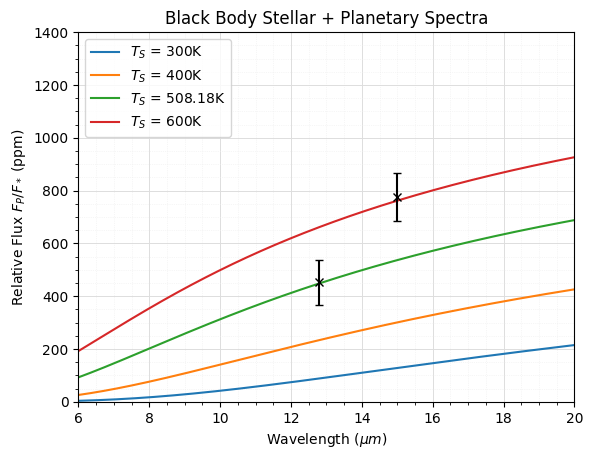

In [20]:
# plot black body curves
bb_300 = evaluate_planck(df['wavelength'], 300)
rel_flux_300 = calc_relative_flux(r_trap1b, bb_300, r_trap1, bb_star)
plt.plot(df['microns'], rel_flux_300, label='$T_S$ = 300K')

bb_400 = evaluate_planck(df['wavelength'], 400)
rel_flux_400 = calc_relative_flux(r_trap1b, bb_400, r_trap1, bb_star)
plt.plot(df['microns'], rel_flux_400, label='$T_S$ = 400K')

relative_flux = calc_relative_flux(r_trap1b, bb_tsurf, r_trap1, bb_star)
plt.plot(df['microns'], relative_flux, label='$T_S$ = %.2fK'%t_surf)

bb_600 = evaluate_planck(df['wavelength'], 600)
rel_flux_600 = calc_relative_flux(r_trap1b, bb_600, r_trap1, bb_star)
plt.plot(df['microns'], rel_flux_600, label='$T_S$ = 600K')

# add literature values of secondary eclipse flux from Ducrot et. al. 2024
plt.errorbar(12.8, 452, yerr=86, marker='x', color='k', capsize=3)
plt.errorbar(15, 775, yerr=90, marker='x', color='k', capsize=3)

# add both major and minor grid lines
plt.grid(which='major', color='#DDDDDD', lw=0.7)
plt.grid(which='minor', color='#EEEEEE', ls=':', lw=0.5)
plt.minorticks_on()

# add title
plt.title('Black Body Stellar + Planetary Spectra')

# add legend
plt.legend(loc='upper left')

# set x and y axis limits
plt.xlim(6, 20)
plt.ylim(0, 1400)

# set the x and y axis labels
plt.xlabel(r'Wavelength ($\mu m$)')
plt.ylabel('Relative Flux $F_P / F_*$ (ppm)')

# show the plot
plt.show()

# **Calculate Relative Flux for Black Body Planet with Real Stellar Spectra**

C:\Users\ers1n25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


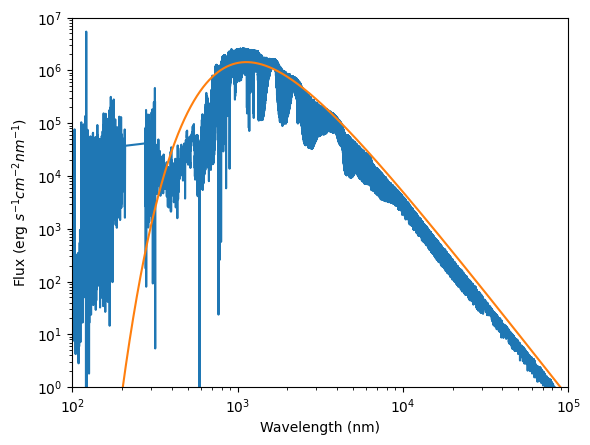

In [21]:
# convert the star flux from being at 1AU to being at the surface
star['surface_flux'] = star['flux'] * ((AU / r_trap1) ** 2)
bb_star_more = evaluate_planck(star['wavelength'], t_trap1)
plt.plot(star['wavelength'], star['surface_flux'])
plt.plot(star['wavelength'], bb_star_more * 1e3) # si to cgs conversion (W m^-2 nm^-1 to erg s^-1 cm^-2 nm^-1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Flux (erg $s^{-1} cm^{-2} nm^{-1}$)')
plt.ylim(1, 1e7)
plt.xlim(1e2, 1e5)
plt.show()

In [22]:
# convert si to cgs units
bb_star_cgs = bb_star * 1e3
bb_300_cgs = bb_300 * 1e3
bb_400_cgs = bb_400 * 1e3
bb_tsurf_cgs = bb_tsurf * 1e3
bb_600_cgs = bb_600 * 1e3

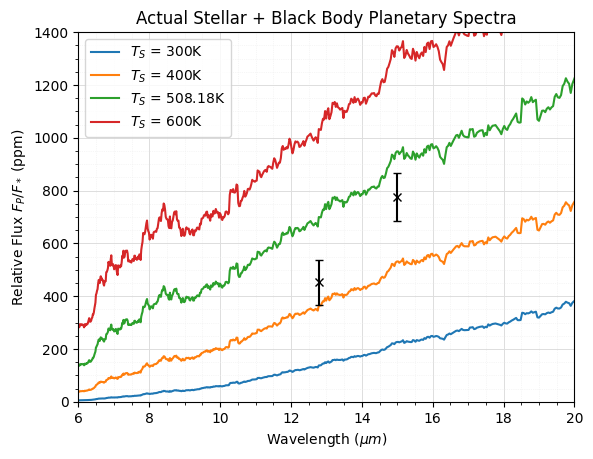

In [23]:
# do interpolation process again but for the surface star flux this time
df['closest_stellar_surf_flux'] = 0.0
for i in range(0, len(df['wavelength'])):
    df.loc[i, 'closest_stellar_surf_flux'] = star['surface_flux'][np.abs(star['wavelength'] - df['wavelength'][i]).argmin()]

# plot scaled black body planet spectra relative to new actual spectra
rel_flux_300_scaled = calc_relative_flux(r_trap1b, bb_300_cgs, r_trap1, df['closest_stellar_surf_flux'])
y_300 = pd.Series(rel_flux_300_scaled).rolling(10).mean()
plt.plot(df['microns'].rolling(10).mean(), y_300, label='$T_S$ = 300K')

rel_flux_400_scaled = calc_relative_flux(r_trap1b, bb_400_cgs, r_trap1, df['closest_stellar_surf_flux'])
y_400 = pd.Series(rel_flux_400_scaled).rolling(10).mean()
plt.plot(df['microns'].rolling(10).mean(), y_400, label='$T_S$ = 400K')

rel_flux_tsurf_scaled = calc_relative_flux(r_trap1b, bb_tsurf_cgs, r_trap1, df['closest_stellar_surf_flux'])
y_tsurf = pd.Series(rel_flux_tsurf_scaled).rolling(10).mean()
plt.plot(df['microns'].rolling(10).mean(), y_tsurf, label='$T_S$ = %.2fK'%t_surf)

rel_flux_600_scaled = calc_relative_flux(r_trap1b, bb_600_cgs, r_trap1, df['closest_stellar_surf_flux'])
y_600 = pd.Series(rel_flux_600_scaled).rolling(10).mean()
plt.plot(df['microns'].rolling(10).mean(), y_600, label='$T_S$ = 600K')

# add literature values of secondary eclipse flux from Ducrot et. al. 2024
plt.errorbar(12.8, 452, yerr=86, marker='x', color='k', capsize=3)
plt.errorbar(15, 775, yerr=90, marker='x', color='k', capsize=3)

# add both major and minor grid lines
plt.grid(which='major', color='#DDDDDD', lw=0.7)
plt.grid(which='minor', color='#EEEEEE', ls=':', lw=0.5)
plt.minorticks_on()

# add title
plt.title('Actual Stellar + Black Body Planetary Spectra')

# add legend
plt.legend()

# set x and y axis limits
plt.xlim(6, 20)
plt.ylim(0, 1400)

# set the x and y axis labels
plt.xlabel(r'Wavelength ($\mu m$)')
plt.ylabel('Relative Flux $F_P / F_*$ (ppm)')

# show the plot
plt.show()

# **Calculate Relative Flux with Real Stellar Spectra and AGNi Surface Emission for Planet**

131.75745796204686 1248.719542477916


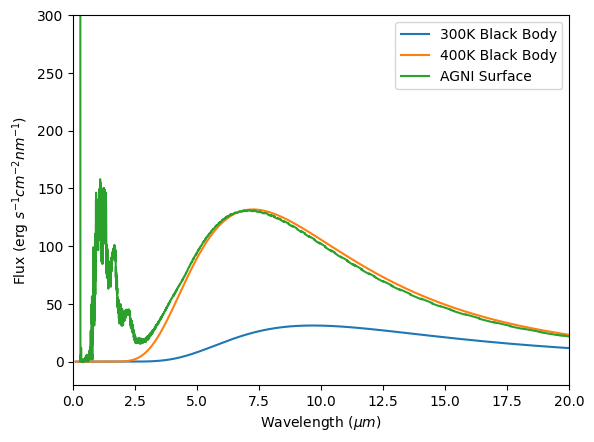

In [24]:
# read in AGNI data for transparent atmosphere simulations of a specific surface
surface = pd.read_csv('./csv/BARE/More Spectral Bands/0.1greybody_407.csv')
surface['microns'] = surface['x_values'] * 1e-3
print(np.max(bb_400_cgs), np.max(surface['surface']))

plt.plot(df['microns'], bb_300_cgs, label='300K Black Body')
plt.plot(df['microns'], bb_400_cgs, label='400K Black Body')
plt.plot(surface['microns'], surface['surface'], label='AGNI Surface')
plt.xlabel(r'Wavelength ($\mu m$)')
plt.ylabel('Flux (erg $s^{-1} cm^{-2} nm^{-1}$)')
plt.legend()
plt.xlim(0, 20)
plt.ylim(-20, 300)
plt.show()

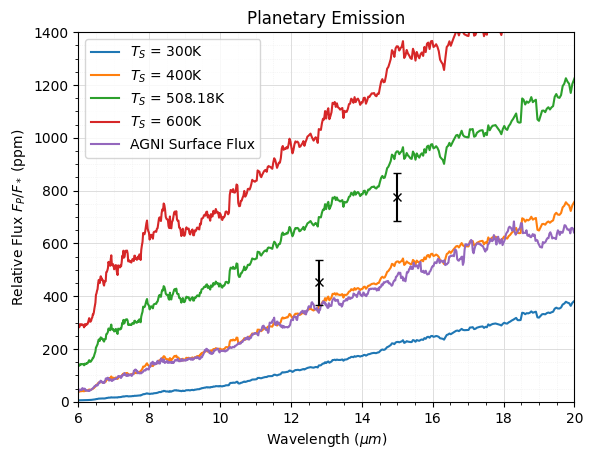

In [ ]:
# do interpolation again, this time for AGNI data and stellar spectra
surface['closest_stellar_flux'] = 0.0
for i in range(0, len(surface['x_values'])):
    surface.loc[i, 'closest_stellar_flux'] = star['surface_flux'][np.abs(star['wavelength'] - surface['x_values'][i]).argmin()]

# plot AGNI relative flux in comparison to black body fluxes
plt.plot(df['microns'].rolling(10).mean(), y_300, label='$T_S$ = 300K')
plt.plot(df['microns'].rolling(10).mean(), y_400, label='$T_S$ = 400K')
plt.plot(df['microns'].rolling(10).mean(), y_tsurf, label='$T_S$ = %.2fK'%t_surf)
plt.plot(df['microns'].rolling(10).mean(), y_600, label='$T_S$ = 600K')

rel_flux_agni = calc_relative_flux(r_trap1b, surface['surface'], r_trap1, surface['closest_stellar_flux'])
plt.plot(surface['microns'].rolling(10).mean(), rel_flux_agni.rolling(10).mean(), label='AGNI Surface Flux')

# add literature values of secondary eclipse flux from Ducrot et. al. 2024
plt.errorbar(12.8, 452, yerr=86, marker='x', color='k', capsize=3)
plt.errorbar(15, 775, yerr=90, marker='x', color='k', capsize=3)

# add both major and minor grid lines
plt.grid(which='major', color='#DDDDDD', lw=0.7)
plt.grid(which='minor', color='#EEEEEE', ls=':', lw=0.5)
plt.minorticks_on()

# add title
plt.title('Planetary Emission')

# add legend
plt.legend()

# set x and y axis limits
plt.xlim(6, 20)
plt.ylim(0, 1400)

# set the x and y axis labels
plt.xlabel(r'Wavelength ($\mu m$)')
plt.ylabel('Relative Flux $F_P / F_*$ (ppm)')

# show the plot
plt.show()

# **Calculate Weighted Averages Using JWST Filter Response**

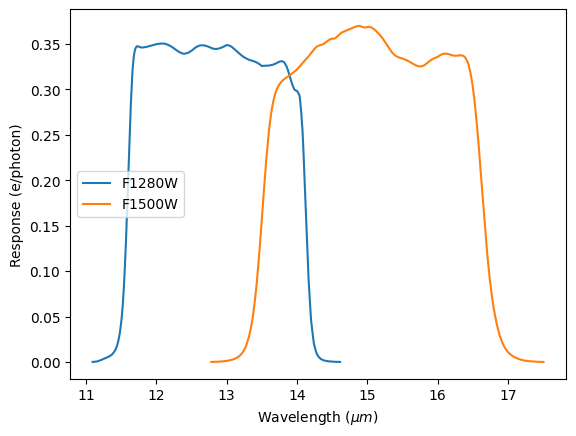

In [26]:
# read in response data
f1280w = pd.read_csv('./misc/utilities/Bare Rock Analysis Files/JWST_MIRI.F1280W.dat', delimiter=' ')
f1280w.columns = ['wavelength_A', 'response']
f1280w['microns'] = f1280w['wavelength_A'] * 1e-4

f1500w = pd.read_csv('./misc/utilities/Bare Rock Analysis Files/JWST_MIRI.F1500W.dat', delimiter=' ')
f1500w.columns = ['wavelength_A', 'response']
f1500w['microns'] = f1500w['wavelength_A'] * 1e-4

plt.plot(f1280w['microns'], f1280w['response'], label='F1280W')
plt.plot(f1500w['microns'], f1500w['response'], label='F1500W')
plt.xlabel(r'Wavelength ($\mu m$)')
plt.ylabel('Response (e/photon)')
plt.legend()
plt.show()

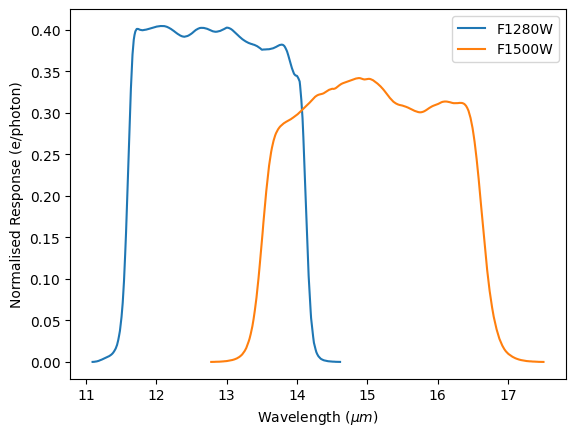

In [27]:
# normalise the curves
area_1280 = trapezoid(f1280w['response'], f1280w['microns'])
f1280w['normalised'] = f1280w['response']/area_1280

area_1500 = trapezoid(f1500w['response'], f1500w['microns'])
f1500w['normalised'] = f1500w['response']/area_1500

plt.plot(f1280w['microns'], f1280w['normalised'], label='F1280W')
plt.plot(f1500w['microns'], f1500w['normalised'], label='F1500W')
plt.xlabel(r'Wavelength ($\mu m$)')
plt.ylabel('Normalised Response (e/photon)')
plt.legend()
plt.show()

In [28]:
# calculate weighted mean of a curve in those filters (input must be normalised)
def calc_weighted_mean(curve_x, curve_y, filter_x, filter_y):
    filter_x_temp = []
    curve_values = []

    for i in range(0, len(filter_x)):
        filter_x_temp.append(curve_x[np.abs(curve_x - filter_x[i]).argmin()]) # only to be used if you want to plot curve and filter on the same x axis intervals
        curve_values.append(curve_y[np.abs(curve_x - filter_x[i]).argmin()])

    weighted_mean = np.average(curve_values, weights=filter_y)
    return weighted_mean

mean_1280_300K = calc_weighted_mean(df['microns'].rolling(10).mean(), y_300, f1280w['microns'], f1280w['normalised'])
mean_1280_400K = calc_weighted_mean(df['microns'].rolling(10).mean(), y_400, f1280w['microns'], f1280w['normalised'])
mean_1280_tsurf = calc_weighted_mean(df['microns'].rolling(10).mean(), y_tsurf, f1280w['microns'], f1280w['normalised'])
mean_1280_600K = calc_weighted_mean(df['microns'].rolling(10).mean(), y_600, f1280w['microns'], f1280w['normalised'])
mean_1280_agni = calc_weighted_mean(surface['microns'], rel_flux_agni, f1280w['microns'], f1280w['normalised'])

mean_1500_300K = calc_weighted_mean(df['microns'].rolling(10).mean(), y_300, f1500w['microns'], f1500w['normalised'])
mean_1500_400K = calc_weighted_mean(df['microns'].rolling(10).mean(), y_400, f1500w['microns'], f1500w['normalised'])
mean_1500_tsurf = calc_weighted_mean(df['microns'].rolling(10).mean(), y_tsurf, f1500w['microns'], f1500w['normalised'])
mean_1500_600K = calc_weighted_mean(df['microns'].rolling(10).mean(), y_600, f1500w['microns'], f1500w['normalised'])
mean_1500_agni = calc_weighted_mean(surface['microns'], rel_flux_agni, f1500w['microns'], f1500w['normalised'])

print(mean_1280_300K, mean_1280_400K, mean_1280_tsurf, mean_1280_600K, mean_1280_agni)
print(mean_1500_300K, mean_1500_400K, mean_1500_tsurf, mean_1500_600K, mean_1500_agni)

140.1277014260881 369.34524066606724 707.3694612093296 1043.1429451701854 353.9097441690608
214.8715071665217 500.9266860040481 891.4522466713711 1263.935132709442 468.9857788735338


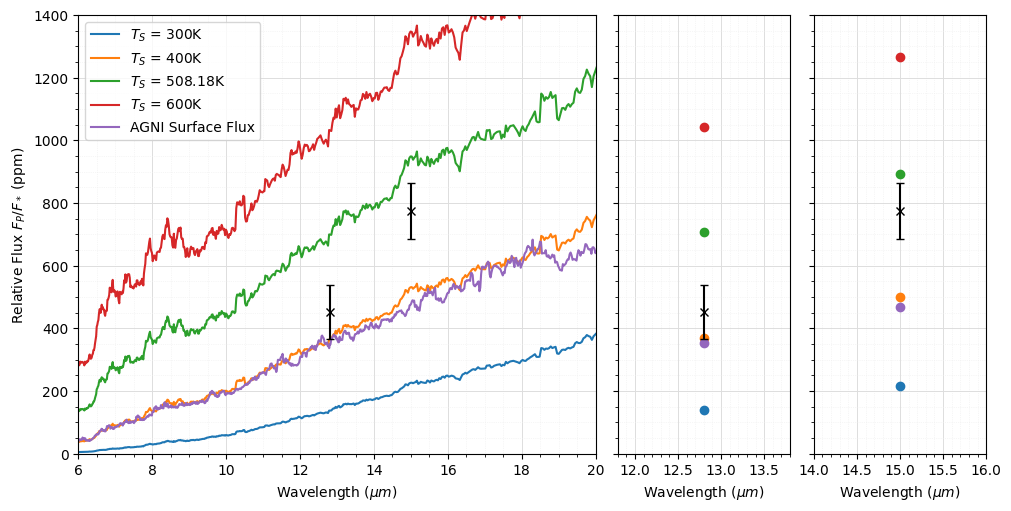

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5), sharey=True, layout='constrained', gridspec_kw={'width_ratios': [3, 1, 1]})

ax1.plot(df['microns'].rolling(10).mean(), y_300, label='$T_S$ = 300K')
ax1.plot(df['microns'].rolling(10).mean(), y_400, label='$T_S$ = 400K')
ax1.plot(df['microns'].rolling(10).mean(), y_tsurf, label='$T_S$ = %.2fK'%t_surf)
ax1.plot(df['microns'].rolling(10).mean(), y_600, label='$T_S$ = 600K')
ax1.plot(surface['microns'].rolling(10).mean(), rel_flux_agni.rolling(10).mean(), label='AGNI Surface Flux')
ax1.errorbar(12.8, 452, yerr=86, marker='x', color='k', capsize=3)
ax1.errorbar(15, 775, yerr=90, marker='x', color='k', capsize=3)
ax1.grid(which='major', color='#DDDDDD', lw=0.7)
ax1.grid(which='minor', color='#EEEEEE', ls=':', lw=0.5)
ax1.minorticks_on()
ax1.legend()
ax1.set_xlim(6, 20)
ax1.set_ylim(0, 1400)
ax1.set_xlabel(r'Wavelength ($\mu m$)')
ax1.set_ylabel('Relative Flux $F_P / F_*$ (ppm)')

ax2.plot(12.8, mean_1280_300K, marker='o')
ax2.plot(12.8, mean_1280_400K, marker='o')
ax2.plot(12.8, mean_1280_tsurf, marker='o')
ax2.plot(12.8, mean_1280_600K, marker='o')
ax2.plot(12.8, mean_1280_agni, marker='o')
ax2.errorbar(12.8, 452, yerr=86, marker='x', color='k', capsize=3)
ax2.grid(which='major', color='#DDDDDD', lw=0.7)
ax2.grid(which='minor', color='#EEEEEE', ls=':', lw=0.5)
ax2.set_xlim(11.8, 13.8)
ax2.set_xlabel(r'Wavelength ($\mu m$)')
ax2.minorticks_on()

ax3.plot(15, mean_1500_300K, marker='o')
ax3.plot(15, mean_1500_400K, marker='o')
ax3.plot(15, mean_1500_tsurf, marker='o')
ax3.plot(15, mean_1500_600K, marker='o')
ax3.plot(15, mean_1500_agni, marker='o')
ax3.errorbar(15, 775, yerr=90, marker='x', color='k', capsize=3)
ax3.grid(which='major', color='#DDDDDD', lw=0.7)
ax3.grid(which='minor', color='#EEEEEE', ls=':', lw=0.5)
ax3.set_xlim(14, 16)
ax3.set_xlabel(r'Wavelength ($\mu m$)')
ax3.minorticks_on()

In [30]:
# find chi squared values for black body curves and an example AGNI curve
def chi_squared(model, data, error):
    temp = 0
    for i in range(0, len(model)):
        temp += ((model[i] - data[i]) ** 2) / (error[i] ** 2)

    return temp

data_points = [452, 775]
data_error = [86, 90]
model_300K = [mean_1280_300K, mean_1500_300K]
model_400K = [mean_1280_400K, mean_1500_400K]
model_tsurf = [mean_1280_tsurf, mean_1500_tsurf]
model_600K = [mean_1280_600K, mean_1500_600K]
model_agni = [mean_1280_agni, mean_1500_agni]

chi_300 = chi_squared(model_300K, data_points, data_error)
chi_400 = chi_squared(model_400K, data_points, data_error)
chi_tsurf = chi_squared(model_tsurf, data_points, data_error)
chi_600 = chi_squared(model_600K, data_points, data_error)
chi_agni = chi_squared(model_agni, data_points, data_error)

print(chi_300, chi_400, chi_tsurf, chi_600, chi_agni)

51.88475540784363 10.197319418798847 10.491622698975666 76.761789730928 12.8620072154572


In [31]:
# calculate chi squared values for all different surfaces at lower spectral resolution (256 bands)
path = './csv/BARE/*.csv'
chi_values_256 = []
surface_temps_256 = []

for fname in glob.glob(path):
    dff = pd.read_csv('%s'%fname)
    dff['microns'] = dff['x_values'] * 1e-3

    dff['closest_stellar_flux'] = 0.0
    for i in range(0, len(dff['x_values'])):
        dff.loc[i, 'closest_stellar_flux'] = star['surface_flux'][np.abs(star['wavelength'] - dff['x_values'][i]).argmin()]

    rel_flux_surfaces = calc_relative_flux(r_trap1b, dff['surface'], r_trap1, dff['closest_stellar_flux'])

    mean_1280 = calc_weighted_mean(dff['microns'], rel_flux_surfaces, f1280w['microns'], f1280w['normalised'])
    mean_1500 = calc_weighted_mean(dff['microns'], rel_flux_surfaces, f1500w['microns'], f1500w['normalised'])
    model_surface = [mean_1280, mean_1500]

    chi = chi_squared(model_surface, data_points, data_error)
    chi_values_256.append(chi)

    file_name = os.path.splitext(os.path.basename(fname))[0]
    surface_temps_256.append(float(file_name[-3:]))
    print('The chi squared value for %s'%fname, ' is %.2f'%chi)

The chi squared value for ./csv/BARE\basaltglass_287.csv  is 58.67
The chi squared value for ./csv/BARE\harzburgite_264.csv  is 69.91
The chi squared value for ./csv/BARE\gabbro_293.csv  is 56.42
The chi squared value for ./csv/BARE\marsbasalticshergottite_319.csv  is 43.25
The chi squared value for ./csv/BARE\rhyolite_250.csv  is 74.39
The chi squared value for ./csv/BARE\norite_336.csv  is 35.85
The chi squared value for ./csv/BARE\phonolite_311.csv  is 46.83
The chi squared value for ./csv/BARE\lunarmarebasalt_358.csv  is 26.40
The chi squared value for ./csv/BARE\tholeiiticbasalt_375.csv  is 28.12
The chi squared value for ./csv/BARE\tephrite_310.csv  is 46.82
The chi squared value for ./csv/BARE\diorite_265.csv  is 68.98
The chi squared value for ./csv/BARE\pyrite_372.csv  is 26.06
The chi squared value for ./csv/BARE\andesite_353.csv  is 31.45
The chi squared value for ./csv/BARE\marsbreccia_378.csv  is 32.45
The chi squared value for ./csv/BARE\hematite_303.csv  is 49.27
The chi

In [32]:
# calculate chi squared values for all different surfaces at higher spectral resolution (4096 bands)
path = './csv/BARE/More Spectral Bands/*.csv'
chi_values_4096 = []
surface_temps_4096 = []

for fname in glob.glob(path):
    dff = pd.read_csv('%s'%fname)
    dff['microns'] = dff['x_values'] * 1e-3

    dff['closest_stellar_flux'] = 0.0
    for i in range(0, len(dff['x_values'])):
        dff.loc[i, 'closest_stellar_flux'] = star['surface_flux'][np.abs(star['wavelength'] - dff['x_values'][i]).argmin()]

    rel_flux_surfaces = calc_relative_flux(r_trap1b, dff['surface'], r_trap1, dff['closest_stellar_flux'])

    mean_1280 = calc_weighted_mean(dff['microns'], rel_flux_surfaces, f1280w['microns'], f1280w['normalised'])
    mean_1500 = calc_weighted_mean(dff['microns'], rel_flux_surfaces, f1500w['microns'], f1500w['normalised'])
    model_surface = [mean_1280, mean_1500]

    chi = chi_squared(model_surface, data_points, data_error)
    chi_values_4096.append(chi)

    file_name = os.path.splitext(os.path.basename(fname))[0]
    surface_temps_4096.append(float(file_name[-3:]))
    print('The chi squared value for %s'%fname, ' is %.2f'%chi)

The chi squared value for ./csv/BARE/More Spectral Bands\basaltglass_287.csv  is 59.90
The chi squared value for ./csv/BARE/More Spectral Bands\harzburgite_264.csv  is 70.89
The chi squared value for ./csv/BARE/More Spectral Bands\gabbro_293.csv  is 57.74
The chi squared value for ./csv/BARE/More Spectral Bands\marsbasalticshergottite_319.csv  is 44.87
The chi squared value for ./csv/BARE/More Spectral Bands\rhyolite_250.csv  is 75.22
The chi squared value for ./csv/BARE/More Spectral Bands\norite_336.csv  is 37.53
The chi squared value for ./csv/BARE/More Spectral Bands\phonolite_311.csv  is 48.34
The chi squared value for ./csv/BARE/More Spectral Bands\lunarmarebasalt_358.csv  is 28.26
The chi squared value for ./csv/BARE/More Spectral Bands\tholeiiticbasalt_375.csv  is 29.96
The chi squared value for ./csv/BARE/More Spectral Bands\tephrite_310.csv  is 48.33
The chi squared value for ./csv/BARE/More Spectral Bands\diorite_265.csv  is 69.94
The chi squared value for ./csv/BARE/More Sp

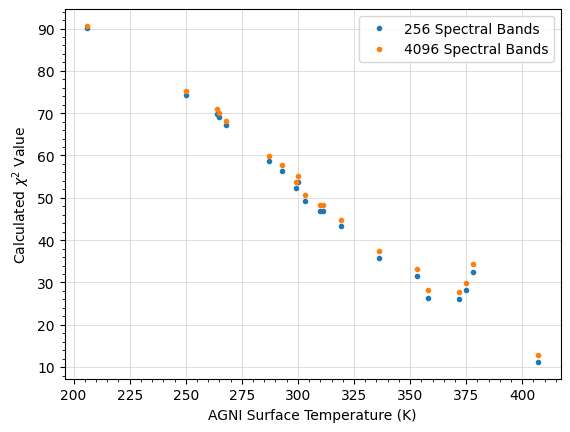

In [33]:
# plot chi squared values vs surface temperature values
plot_chi_256 = pd.DataFrame({
    'surface_t': surface_temps_256,
    'chi_values': chi_values_256
})
plot_chi_256 = plot_chi_256.sort_values(by='surface_t')

plot_chi_4096 = pd.DataFrame({
    'surface_t': surface_temps_4096,
    'chi_values': chi_values_4096
})
plot_chi_4096 = plot_chi_4096.sort_values(by='surface_t')

plt.plot(plot_chi_256['surface_t'], plot_chi_256['chi_values'], ls='None', marker='.', label='256 Spectral Bands')
plt.plot(plot_chi_4096['surface_t'], plot_chi_4096['chi_values'], ls='None', marker='.', label='4096 Spectral Bands')
plt.xlabel('AGNI Surface Temperature (K)')
plt.ylabel(r'Calculated $\chi^2$ Value')
plt.legend()
plt.grid(which='major', color='#DDDDDD', lw=0.7)
plt.minorticks_on()
plt.show()